In [1]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_excel("/content/dataset.xlsx")
data.head()
data.tail()

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset.xlsx'

In [ ]:

y = data['AR'].values # valor de referencia AR

data = data.drop('Wavelength', axis=1)
data = data.drop('Tank', axis=1)
data = data.drop('TA', axis=1)
data = data.drop('AV', axis=1)
data = data.drop('AT', axis=1)
data = data.drop('pH', axis=1)
data = data.drop('MV', axis=1)
data = data.drop('AR', axis=1)
data = data.drop('Date', axis=1)

X = data #dados do espectro

wl = np.arange(350,2501,1) #comprimento de onda

X.head()

,350,351,352,353,354,355,356,357,358,359,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1.631373,1.583009,1.688945,1.880755,1.719132,1.749026,1.787512,1.707210,1.788553,1.709570,...,3.480935,3.224706,3.091417,2.834518,2.852583,3.005980,2.809721,3.016107,3.529182,2.870795
1,1.569768,1.619258,1.908904,2.260184,1.610376,1.713062,1.904372,1.688036,1.801348,1.701634,...,2.859877,2.830242,2.767661,2.784210,2.892849,3.023952,3.379469,5.663446,3.147727,2.639841
2,1.649704,1.591111,1.595969,1.665178,1.592532,1.694299,1.769089,1.650012,1.710203,1.672124,...,2.855198,2.637099,2.585754,2.539939,2.538623,2.640047,2.587395,2.542342,2.561586,2.546457
3,1.752614,1.671143,1.786201,2.081373,1.800722,1.834436,1.819969,1.619182,1.589644,1.612484,...,2.728690,2.741771,2.985479,2.805321,2.720138,2.795015,2.863823,3.246327,5.823909,5.823909
4,1.529986,1.671512,1.957634,2.084863,1.745174,1.631412,1.646875,1.721262,1.674133,1.622133,...,2.912330,3.170591,3.521192,3.608611,5.823909,5.823909,4.138614,3.565699,3.083535,2.765076


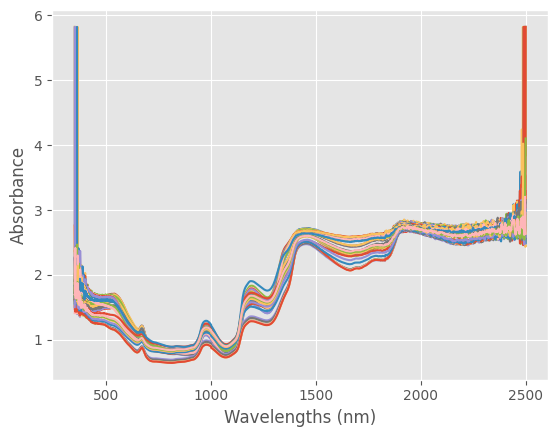

In [ ]:
with plt.style.context('ggplot'):
    plt.plot(wl, X.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")

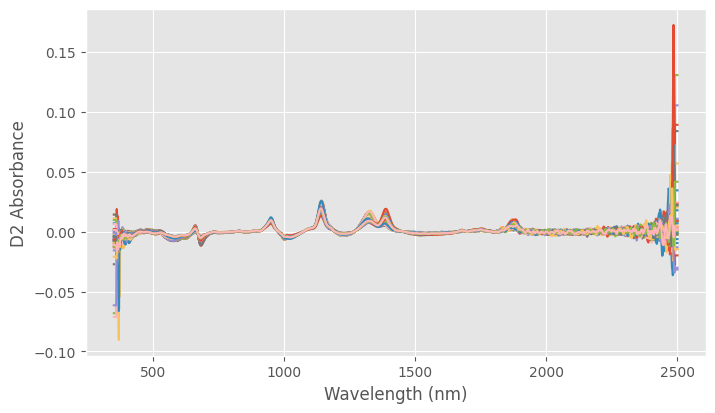

In [ ]:
X2 = savgol_filter(X, 20, polyorder = 1,deriv=1)

# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

In [ ]:
df = pd.DataFrame(X2)

filename = 'dataset_derivada_ordem_1.xlsx'

df.to_excel(filename, index=False)

print("Dataset exported successfully to Excel.")

Dataset exported successfully to Excel.


In [ ]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):

    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''

    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)

    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$AR')
        plt.ylabel('Measured $^{\circ}$AR')

        plt.show()


    return y_cv

100% completed
Suggested number of components:  4



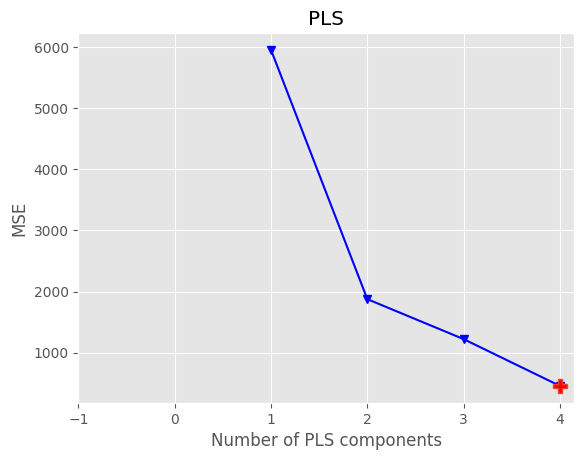

R2 calib: 0.983
R2 CV: 0.932
MSE calib: 117.792
MSE CV: 456.911


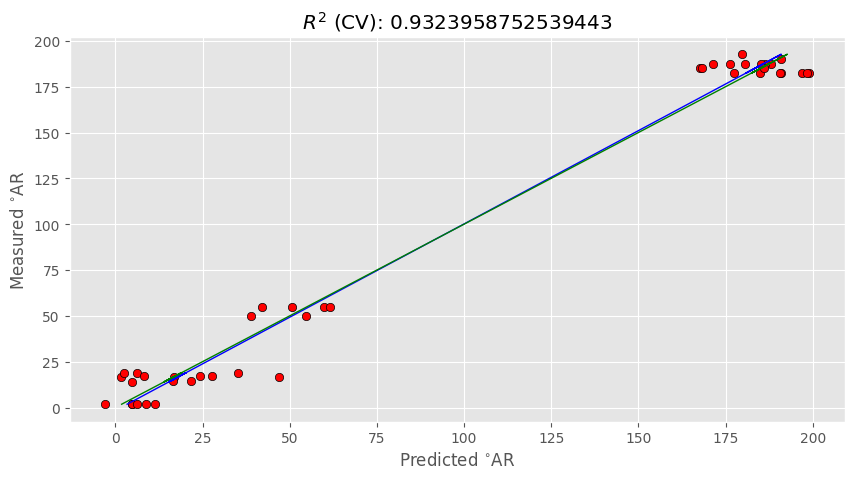

In [ ]:
a = optimise_pls_cv(X,y,5, plot_components=True)

In [ ]:
a

array([[212.87195884],
       [201.05233301],
       [218.07756454],
       [215.10375794],
       [206.98871491],
       [191.08538273],
       [185.65461948],
       [172.80014636],
       [183.32904643],
       [183.21940747],
       [179.94483068],
       [181.74045299],
       [161.54200107],
       [154.38368752],
       [161.72429706],
       [148.04799603],
       [160.85425115],
       [156.35959484],
       [ 24.64315409],
       [ 63.19372339],
       [ 65.83637168],
       [ 49.46034402],
       [ 30.92752832],
       [ 52.22589564],
       [  1.10575445],
       [  0.56631317],
       [ 10.54373613],
       [  4.33279229],
       [ 35.78781135],
       [ 61.72135312],
       [ -1.96236902],
       [  1.99652634],
       [ 20.62876207],
       [ 22.13904598],
       [ 32.98409201],
       [ 26.50268439],
       [ 17.08182129],
       [ 11.95624606],
       [ 28.27784067],
       [ 16.98268914],
       [ 37.43679522],
       [ 35.31964283]])

In [ ]:
df = pd.DataFrame(a)

filename = 'dataset_AR_prediction.xlsx'

df.to_excel(filename, index=False)

print("Dataset exported successfully to Excel.")

Dataset exported successfully to Excel.
